In [3]:
from argparse import ArgumentParser

from initialisation import init_qz
from datasets import IHDP
from evaluation import Evaluator, get_y0_y1
from networks import p_x_z, p_t_z, p_y_zt, q_t_x, q_y_xt, q_z_tyx

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
from torch.distributions import normal
from torch import optim

dataset = IHDP()

In [36]:
%load_ext autoreload
%autoreload 2

from lr import lr1, lr2, get_train_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-
train ate 0.894608966665525
train pehe 4.785070915840782
test ate 1.7670829300809476
test pehe 4.092200283945308
-
train ate 0.1062516811144301
train pehe 2.074089101504198
test ate 0.4196854865701004
test pehe 1.6589961063537602


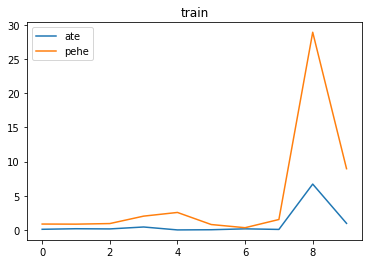

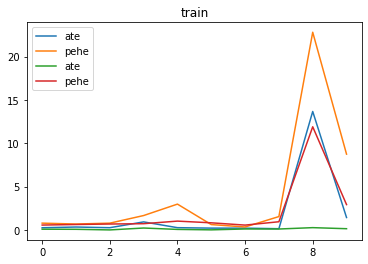

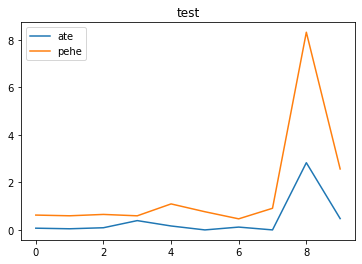

In [51]:
def plot_score(scores, train):
    
    lab = ['ite', 'ate', 'pehe']
    for i in range(1,3):
        xx = [x[i] for x in scores]
        print(train, lab[i], np.mean(xx))
        plt.plot(xx, label = lab[i])
        plt.legend()
        plt.title(train)
        
        
for lr in [lr1, lr2]:
    train_score = []
    test_score = []
    print('-')
    for i, (train, valid, test, contfeats, binfeats) in enumerate(dataset.get_train_valid_test()):
#     print('\nReplication %i/%i' % (i + 1, 1))
        (xtr, ttr, ytr), (y_cftr, mu0tr, mu1tr) = train
        (xva, tva, yva), (y_cfva, mu0va, mu1va) = valid
        (xte, tte, yte), (y_cfte, mu0te, mu1te) = test
    #     break
        # set evaluator objects
        evaluator_train = Evaluator(yalltr, talltr, y_cf=np.concatenate([y_cftr, y_cfva], axis=0),
                                    mu0=np.concatenate([mu0tr, mu0va], axis=0), mu1=np.concatenate([mu1tr, mu1va], axis=0))
#         evaluator_train = Evaluator(ytr, ttr, y_cf=y_cftr,
#                                     mu0=mu0tr, mu1=mu1tr)
        evaluator_test = Evaluator(yte, tte, y_cf=y_cfte, mu0=mu0te, mu1=mu1te)


        xalltr, talltr, yalltr, xte, tte = get_train_data(train, valid, test, contfeats, binfeats)
        y0_tr, y1_tr, y0_te, y1_te = lr(xalltr, talltr, yalltr, xte, tte)
#         y0_tr, y1_tr, y0_te, y1_te = lr(xtr, ttr, ytr, xte, tte)
        train_score.append(evaluator_train.calc_stats(y1_tr, y0_tr))
        test_score.append(evaluator_test.calc_stats(y1_te, y0_te))
    
    plot_score(train_score, 'train')
    plt.figure()
    plot_score(test_score, 'test')

In [52]:
# lr1 pehe 4.5 / 4
# lr2 pehe 2 / 5.8 (1.6 if val)
# pytoch pehe 0.9 / 4
# CEVAE pehe 2.6+1 / 2.0+.9

In [ ]:
# ATE
# lr2 .1 / .42
# CEVAE .53+.3 / .34+.05

In [53]:
import sklearn
sklearn.show_versions()


System:
    python: 3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC 7.3.0]
executable: /home/thomas/anaconda3/bin/python
   machine: Linux-5.0.0-31-generic-x86_64-with-debian-buster-sid

Python deps:
       pip: 19.1.1
setuptools: 41.0.1
   sklearn: 0.22.dev0
     numpy: 1.17.2
     scipy: 1.3.1
    Cython: 0.29.12
    pandas: 0.24.2
matplotlib: 3.1.0
    joblib: 0.13.2


In [22]:
np.mean(test_score), np.std(test_score), np.var(test_score)

(4.092200283945308, 6.670960768257998, 44.50171757163733)

In [23]:
test_score

[0.7824887581548252,
 0.6803051523114052,
 0.7810149563851666,
 1.6586685423325294,
 2.977228516888689,
 0.6174660083260175,
 0.34082372695953084,
 1.5406678878313027,
 22.80074635712828,
 8.742592933135336]

In [73]:
np.mean(test_score[:-2] ), np.std(test_score[:-2] ), np.var(test_score[:-2] )

(5.450423674478027, 1.9515279733764033, 3.808461430870612)

In [63]:
test_score

[0.7824887581548252,
 0.6803051523114052,
 0.7810149563851666,
 1.6586685423325294,
 2.977228516888689,
 0.6174660083260175,
 0.34082372695953084,
 1.5406678878313027,
 22.80074635712828,
 8.742592933135336]

In [11]:
train, valid, test, contfeats, binfeats = a.__next__()

In [43]:
print(x.shape)
print(t.shape)
print(y.shape)
print(y_cf.shape)
print(mu_0.shape)
print(mu_1.shape)

(470, 25)
(470, 1)
(470, 1)
(470, 1)
(470, 1)
(470, 1)


In [52]:
from sklearn.linear_model import LinearRegression
xt = np.concatenate((x,t), axis = 1)
xt_ = np.concatenate((x_,t_), axis = 1)

lr1 = LinearRegression()
lr1.fit(xt, y)
y_hat = lr1.predict(xt)
y_hat_ = lr1.predict(xt_)



In [54]:
t0 = np.zeros(t.shape)
t1 = np.zeros(t.shape) + 1
xt0 = np.concatenate((x,t0), axis = 1)
xt1 = np.concatenate((x,t0), axis = 1)

y_0 = lr1.predict(xt0)
y_1 = lr1.predict(xt1)

train pehe 4.088907893143128
test pehe 4.384994223496848


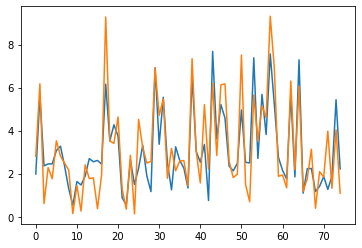

In [55]:
plt.plot(y_hat_)
plt.plot(y_)

print('train pehe', sqrt_pehe(mu_1, mu_0, y_0, y_1))
print('test pehe', sqrt_pehe(mu_1_, mu_0_, y_hat_, y_))